In [8]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

In [9]:
# global constants
Sv=1.e9 # m^3/sec

In [10]:
# salinity only, linear forcing 
input_data = np.load('data/input_sal_temp_linear.npy')
output_data = np.load('data/output_sal_temp_linear.npy')

In [11]:
X_train, X_rem, y_train, y_rem = train_test_split(input_data, output_data, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.mean_,scaler.scale_

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

Y_train = keras.utils.to_categorical(y_train)
Y_val = keras.utils.to_categorical(y_val)
Y_test = keras.utils.to_categorical(y_test)

In [13]:
# defining the MLP
model = Sequential()
model.add(Dense(12, input_dim=5, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# Train the model on the training set and validate on the validation set
model_eval = model.fit(X_train_scaled, Y_train, epochs=10, batch_size=8, validation_data=(X_val_scaled, Y_val))

Epoch 1/10
10000/10000 [==============================] - 10s 969us/step - loss: 0.0162 - accuracy: 0.9997 - val_loss: 4.3336e-04 - val_accuracy: 0.9998
Epoch 2/10
10000/10000 [==============================] - 11s 1ms/step - loss: 5.7950e-04 - accuracy: 0.9999 - val_loss: 3.2311e-04 - val_accuracy: 0.9998
Epoch 3/10
10000/10000 [==============================] - 11s 1ms/step - loss: 5.1209e-04 - accuracy: 0.9999 - val_loss: 1.1388e-04 - val_accuracy: 1.0000
Epoch 4/10
10000/10000 [==============================] - 11s 1ms/step - loss: 4.3284e-04 - accuracy: 0.9999 - val_loss: 1.2833e-04 - val_accuracy: 0.9999
Epoch 5/10
10000/10000 [==============================] - 11s 1ms/step - loss: 3.9143e-04 - accuracy: 0.9999 - val_loss: 8.6178e-05 - val_accuracy: 1.0000
Epoch 6/10
10000/10000 [==============================] - 14s 1ms/step - loss: 3.0656e-04 - accuracy: 0.9999 - val_loss: 6.1099e-05 - val_accuracy: 1.0000
Epoch 7/10
10000/10000 [==============================] - 10s 976us/step

In [15]:
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

313/313 [==============================] - 0s 759us/step - loss: 1.2818e-05 - accuracy: 1.0000
Test loss: 1.2817844435630832e-05
Test accuracy: 1.0


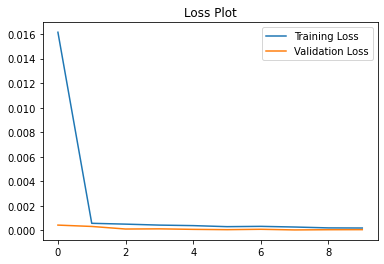

In [16]:
plt.plot(model_eval.history['loss'], label='Training Loss');
plt.plot(model_eval.history['val_loss'], label='Validation Loss');
plt.title('Loss Plot');
plt.legend();

In [17]:
y_pred_all = model.predict(input_scaled)

3125/3125 [==============================] - 2s 718us/step


In [18]:
y_labels_all = np.argmax(y_pred_all, axis=-1)

In [19]:
false_indices_sal_temp_linear = []
for i in range(len(y_labels_all)):
    if y_labels_all[i] != output_data[i]:
        false_indices_sal_temp_linear.append(i)

In [20]:
qplot = np.load('data/q_sal_temp_linear.npy')

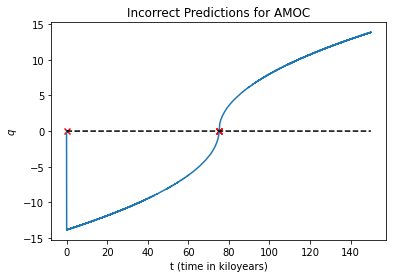

In [22]:
plt.plot(input_data[:, 0], qplot/Sv);
plt.plot(input_data[:, 0], input_data[:, 0]*0,'k--');
plt.xlabel('t (time in kiloyears)');
plt.ylabel('$q$');
plt.title('Incorrect Predictions for AMOC');
plt.scatter([input_data[:, 0][i] for i in false_indices_sal_temp_linear], [qplot[i]/Sv for i in false_indices_sal_temp_linear], marker='x', c='red');

In [23]:
# training the ensemble 
for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    history = model.fit(X_train_scaled, Y_train,
                    batch_size=8,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_scaled, Y_val),
                    callbacks=[es])#,
    os.makedirs("models", exist_ok=True)
    model.save('models/stommel_model_ts_linear_'+str(i)+'.h5')

0
1
2
3
4
5
6
Epoch 8: early stopping
7
8
9


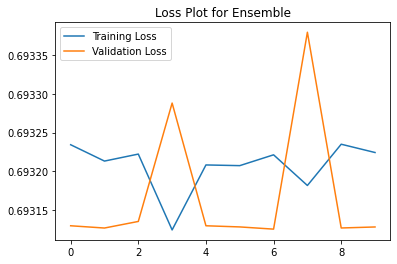

In [24]:
plt.plot(history.history['loss'], label='Training Loss');
plt.plot(history.history['val_loss'], label='Validation Loss');
plt.title('Loss Plot for Ensemble')
plt.legend();

In [25]:
for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.load_weights('models/stommel_model_ts_linear_'+str(i)+'.h5')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_scaled, Y_test)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')

0
313/313 [==============================] - 0s 781us/step - loss: 2.8520e-05 - accuracy: 1.0000
Test loss: 2.8519576517282985e-05
Test accuracy: 1.0
1
313/313 [==============================] - 0s 928us/step - loss: 3.0977e-05 - accuracy: 1.0000
Test loss: 3.0976691050454974e-05
Test accuracy: 1.0
2
313/313 [==============================] - 0s 799us/step - loss: 3.7061e-05 - accuracy: 1.0000
Test loss: 3.7061297916807234e-05
Test accuracy: 1.0
3
313/313 [==============================] - 0s 745us/step - loss: 2.7053e-04 - accuracy: 0.9999
Test loss: 0.0002705298538785428
Test accuracy: 0.9998999834060669
4
313/313 [==============================] - 0s 809us/step - loss: 4.2231e-04 - accuracy: 0.9998
Test loss: 0.0004223130235914141
Test accuracy: 0.9998000264167786
5
313/313 [==============================] - 0s 1ms/step - loss: 1.0149e-06 - accuracy: 1.0000
Test loss: 1.0148977480639587e-06
Test accuracy: 1.0
6
313/313 [==============================] - 1s 1ms/step - loss: 0.6932 - 

In [26]:
datapredicted_results_ensemble = np.nan * np.zeros((10, input_scaled.shape[0], 2))

for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.load_weights('models/stommel_model_ts_linear_'+str(i)+'.h5')
    datapredicted = model.predict(input_scaled)
    datapredicted_results_ensemble[i,...] = datapredicted

0
3125/3125 [==============================] - 2s 623us/step
1
3125/3125 [==============================] - 3s 898us/step
2
3125/3125 [==============================] - 2s 587us/step
3
3125/3125 [==============================] - 3s 831us/step
4
3125/3125 [==============================] - 2s 750us/step
5
3125/3125 [==============================] - 2s 768us/step
6
3125/3125 [==============================] - 2s 583us/step
7
3125/3125 [==============================] - 3s 837us/step
8
3125/3125 [==============================] - 2s 658us/step
9
3125/3125 [==============================] - 2s 590us/step


In [27]:
y_pred_ensemble = np.mean(datapredicted_results_ensemble, 0).argmax(axis=-1)

In [28]:
false_indices_ts_linear_ensemble = []

In [29]:
for i in range(len(y_pred_ensemble)):
    if y_pred_ensemble[i] != output_data[i]:
        false_indices_ts_linear_ensemble.append(i)

In [32]:
false_indices_ts_linear_ensemble

[0, 50146, 50147, 50148]

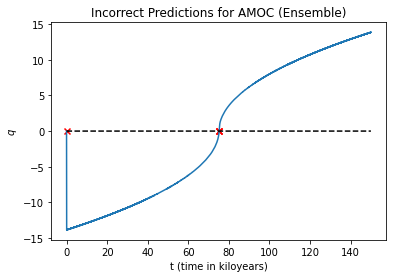

In [33]:
plt.plot(input_data[:, 0], qplot/Sv);
plt.plot(input_data[:, 0], input_data[:, 0]*0,'k--');
plt.xlabel('t (time in kiloyears)');
plt.ylabel('$q$');
plt.title('Incorrect Predictions for AMOC (Ensemble)');
plt.scatter([input_data[:, 0][i] for i in false_indices_ts_linear_ensemble], [qplot[i]/Sv for i in false_indices_ts_linear_ensemble], marker='x', c='red');

In [34]:
# salinity and temp, sine forcing 
input_data = np.load('data/input_sal_temp_sine.npy')
output_data = np.load('data/output_sal_temp_sine.npy')

In [35]:
X_train, X_rem, y_train, y_rem = train_test_split(input_data, output_data, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

In [36]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.mean_,scaler.scale_

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

Y_train = keras.utils.to_categorical(y_train)
Y_val = keras.utils.to_categorical(y_val)
Y_test = keras.utils.to_categorical(y_test)

In [39]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
# Train the model on the training set and validate on the validation set
model_eval = model.fit(X_train_scaled, Y_train, epochs=10, batch_size=8, validation_data=(X_val_scaled, Y_val))

Epoch 1/10
10000/10000 [==============================] - 10s 948us/step - loss: 0.0663 - accuracy: 0.9950 - val_loss: 0.0037 - val_accuracy: 0.9996
Epoch 2/10
10000/10000 [==============================] - 10s 966us/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 5.7532e-04 - val_accuracy: 0.9999
Epoch 3/10
10000/10000 [==============================] - 9s 930us/step - loss: 5.4119e-04 - accuracy: 0.9999 - val_loss: 3.8208e-04 - val_accuracy: 0.9999
Epoch 4/10
10000/10000 [==============================] - 9s 935us/step - loss: 3.1666e-04 - accuracy: 0.9999 - val_loss: 1.7139e-04 - val_accuracy: 1.0000
Epoch 5/10
10000/10000 [==============================] - 10s 967us/step - loss: 2.9425e-04 - accuracy: 0.9999 - val_loss: 1.0892e-04 - val_accuracy: 1.0000
Epoch 6/10
10000/10000 [==============================] - 10s 981us/step - loss: 2.5170e-04 - accuracy: 0.9999 - val_loss: 2.7009e-04 - val_accuracy: 0.9999
Epoch 7/10
10000/10000 [==============================] - 10s 982us/step

In [41]:
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

313/313 [==============================] - 0s 896us/step - loss: 6.0085e-04 - accuracy: 0.9998
Test loss: 0.0006008456111885607
Test accuracy: 0.9998000264167786


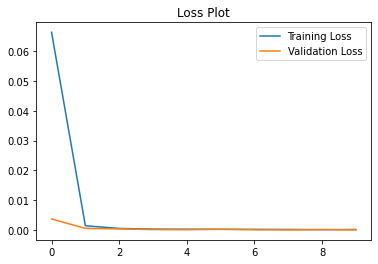

In [42]:
plt.plot(model_eval.history['loss'], label='Training Loss');
plt.plot(model_eval.history['val_loss'], label='Validation Loss');
plt.title('Loss Plot');
plt.legend();

In [43]:
y_pred_all = model.predict(input_scaled)

3125/3125 [==============================] - 2s 661us/step


In [44]:
y_labels_all = np.argmax(y_pred_all, axis=-1)

In [45]:
false_indices_sal_temp_sine = []
for i in range(len(y_labels_all)):
    if y_labels_all[i] != output_data[i]:
        false_indices_sal_temp_sine.append(i)

In [47]:
qplot = np.load('data/q_sal_temp_sine.npy')

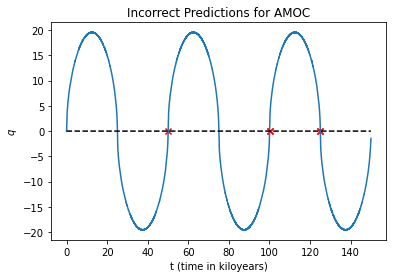

In [48]:
plt.plot(input_data[:, 0], qplot/Sv);
plt.plot(input_data[:, 0], input_data[:, 0]*0,'k--');
plt.xlabel('t (time in kiloyears)');
plt.ylabel('$q$');
plt.title('Incorrect Predictions for AMOC');
plt.scatter([input_data[:, 0][i]for i in false_indices_sal_temp_sine], [qplot[i]/Sv for i in false_indices_sal_temp_sine], marker='x', c='red');

In [49]:
# training the ensemble 
for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    history = model.fit(X_train_scaled, Y_train,
                    batch_size=8,
                    epochs=10,
                    verbose=0,
                    validation_data=(X_val_scaled, Y_val),
                    callbacks=[es])#,
    os.makedirs("models", exist_ok=True)
    model.save('models/stommel_model_ts_sine_'+str(i)+'.h5')

0
1
2
3
4
5
6
7
8
9


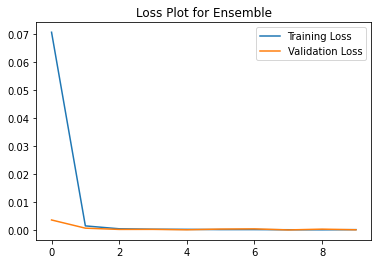

In [50]:
plt.plot(history.history['loss'], label='Training Loss');
plt.plot(history.history['val_loss'], label='Validation Loss');
plt.title('Loss Plot for Ensemble')
plt.legend();

In [51]:
for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.load_weights('models/stommel_model_ts_sine_'+str(i)+'.h5')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    loss, accuracy= model.evaluate(X_test_scaled, Y_test)
    print(f'Test loss: {loss}')
    print(f'Test accuracy: {accuracy}')

0
313/313 [==============================] - 0s 882us/step - loss: 1.9215e-04 - accuracy: 0.9999
Test loss: 0.0001921507209772244
Test accuracy: 0.9998999834060669
1
313/313 [==============================] - 0s 914us/step - loss: 2.7962e-05 - accuracy: 1.0000
Test loss: 2.796238368318882e-05
Test accuracy: 1.0
2
313/313 [==============================] - 0s 757us/step - loss: 5.2366e-05 - accuracy: 1.0000
Test loss: 5.236604920355603e-05
Test accuracy: 1.0
3
313/313 [==============================] - 0s 765us/step - loss: 5.3026e-04 - accuracy: 0.9997
Test loss: 0.0005302649224177003
Test accuracy: 0.9997000098228455
4
313/313 [==============================] - 0s 818us/step - loss: 5.3513e-05 - accuracy: 1.0000
Test loss: 5.351263826014474e-05
Test accuracy: 1.0
5
313/313 [==============================] - 0s 820us/step - loss: 1.2610e-04 - accuracy: 0.9999
Test loss: 0.00012609906843863428
Test accuracy: 0.9998999834060669
6
313/313 [==============================] - 0s 754us/step -

In [53]:
datapredicted_results_ensemble = np.nan * np.zeros((10, input_scaled.shape[0], 2))

for i in range(10):
    print(i)
    model = Sequential()
    model.add(Dense(12, input_dim=5, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.load_weights('models/stommel_model_ts_sine_'+str(i)+'.h5')
    datapredicted = model.predict(input_scaled)
    datapredicted_results_ensemble[i,...] = datapredicted

0
3125/3125 [==============================] - 2s 608us/step
1
3125/3125 [==============================] - 2s 705us/step
2
3125/3125 [==============================] - 2s 608us/step
3
3125/3125 [==============================] - 2s 625us/step
4
3125/3125 [==============================] - 2s 597us/step
5
3125/3125 [==============================] - 2s 583us/step
6
3125/3125 [==============================] - 2s 583us/step
7
3125/3125 [==============================] - 2s 591us/step
8
3125/3125 [==============================] - 2s 635us/step
9
3125/3125 [==============================] - 2s 597us/step


In [54]:
y_pred_ensemble = np.mean(datapredicted_results_ensemble, 0).argmax(axis=-1)

In [55]:
false_indices_ts_sine_ensemble = []

In [56]:
for i in range(len(y_pred_ensemble)):
    if y_pred_ensemble[i] != output_data[i]:
        false_indices_ts_sine_ensemble.append(i)

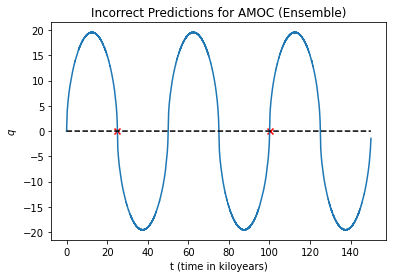

In [57]:
plt.plot(input_data[:, 0], qplot/Sv);
plt.plot(input_data[:, 0], input_data[:, 0]*0,'k--');
plt.xlabel('t (time in kiloyears)');
plt.ylabel('$q$');
plt.title('Incorrect Predictions for AMOC (Ensemble)');
plt.scatter([input_data[:, 0][i] for i in false_indices_ts_sine_ensemble], [qplot[i]/Sv for i in false_indices_ts_sine_ensemble], marker='x', c='red');